In [ ]:
%%html
<marquee style='width: 90%; color: blue;'><b>INSTITUTO INFNET | ESCOLA SUPERIOR DA
TECNOLOGIA DA INFORMAÇÃO</b></marquee>

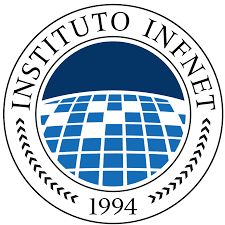

<h2>Pós-graduação MIT em Inteligência Artificial, Machine Learning & Deep Learning</h2>

<h3>Projeto da da disciplina de Mineração de texto com stack ELK.</h3>

Bloco: Mineração de Texto e Processamento de Linguagem Natural

Docente: Felipe Fink Grael

Aluno: Winicius Botelho Faquieri 

---

### Sumário
* [Dataset](#dataset)
* [Análise de Texto com Elasticsearch](#analyzer)
* [Mapping e Configurações de Índice](#mapping)
* [Imitando k-NN Com a query More Like This](#MLT)



---

<img src="www/Amazon_logo.svg.png" width="300"/>

# [Dataset](#intro)


Este conjunto de dados contém reviews para instrumentos musicais comprados na Amazon - http://jmcauley.ucsd.edu/data/amazon/, no período de 2004 a 2014. Os produtos receberam diversas avaliações de clientes, classificadas em um intervalo de 1 a 5. Mais importante do que a nota atribuída ao produto são os comentários ou reviews, onde os clientes que já adquiriram um produto específico relatam e detalham a sua experiência, desde a chegada do produto no destino até a qualidade do produto em si. O dataset foi obtido da plataforma Kaggle e possui 10.261 registros com as seguintes variáveis:  

|Colunas        | Descrição                                        | N° Registros         |
|---------------|--------------------------------------------------|----------------------|
|reviewerID     | ID do revisor                                    | 10.261               |
|asin           | ID do produto                                    | 10.261               |
|reviewerName   | Nome do revisor                                  | 10.261               |
|helpful        | Classificação de utilidade da revisão            | 10.261               |
|reviewText     | Campo textual (resenha /crítica)                 | 10.261               |
|overall        | Classificação atribuída (1 a 5)                  | 10.261               |
|summary        | Resumo da revisão                                | 10.261               |
|unixReviewTime | hora da revisão (hora unix)                      | 10.261               |
|reviewTime     | hora da revisão (bruto)                          | 10.261               |




**Objetivos**: No presente trabalho utilizaremos ténicas de NLP para inferir através da análise desses comentários se o sentimento do cliente foi positivo, neutro ou negativo. Mais especificamente, utilizaremos a query More Like This para realizar a predição do sentimento do cliente, simulando o algoritmo KNN (K Nearest Neighbor).

In [254]:
# Bibliotecas:
import pandas as pd
from tqdm.auto import tqdm
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import urllib3
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [10]:
tqdm.pandas()

df = pd.read_json("data/data_raw.json", orient='records', lines=True)

# Visualizando uma amostra aleatória de 10 registros:
df.sample(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
3628,A3N27L13CWJ9HY,B0006IQNCK,D. R. Smith,"[4, 4]",I love these strings because the sounds are so...,5,Good tones,1317945600,"10 7, 2011"
753,A8AF0VV2LP4LV,B0002D0CA8,Ron1414,"[0, 0]","I used to use Elixir Nano string, and a good a...",5,Excellent,1399334400,"05 6, 2014"
5254,A2IZ3ST24HSO4H,B000P5LVSK,David McCarthy,"[0, 0]",I play metal so I need a strong pick (the Jazz...,5,"one of my fav ""Jazz III"" guitar pics",1379376000,"09 17, 2013"
659,A19Q4B515ENF9C,B0002D0096,Richard L. Chism,"[0, 0]",I bought this amp to replace a Squier SP-10 th...,5,Awesome Effects and a Great Sound,1381449600,"10 11, 2013"
7028,A306YUQBEB2R9T,B001W99HE8,debi,"[0, 0]",This microphone pics up instruments quite a bi...,5,GLS Seems Better than Shure!,1358726400,"01 21, 2013"
5176,A10044ECXDUVKS,B000NJ2TIE,Dean J Copely,"[0, 0]",Surprised really. For the price I dont think I...,4,These are actually very nice,1345161600,"08 17, 2012"
8927,A2Y2U697SS98E1,B004Z17008,"John Wade Long Jr. ""LongJnSilver""","[0, 0]",The Snark is great. I have 2 for my 4 ukuleles...,5,A+++,1398297600,"04 24, 2014"
9733,A7IZNVL7JXLM,B007T8OGLK,"Carver ""Gadget guy""","[4, 6]","I got this from a ""direct from china"" vendor. ...",3,Not bad for the price,1337817600,"05 24, 2012"
2076,A3QTFLU2ZWH7WS,B0002F7K7Y,Audie,"[1, 1]",I love D'Adarrio strings. Great tone and it la...,5,D'Adarrio EXL140-3D Nickel Wound Electric Guit...,1350345600,"10 16, 2012"
7452,AJK15Q9JOEHRH,B002RLLD88,aceofbase,"[0, 0]","Nice accessory, hold plenty of sticks, and the...",5,Nice accessory,1404691200,"07 7, 2014"


In [11]:
# Algumas informações sobre os dados:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10234 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


In [12]:
# Verificando valores nulos
print('The null values in the dataset:')
df.isnull().sum()

The null values in the dataset:


reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [13]:
# A coluna 'reviewerName' contém o nome do revisor e não é relevante para análise e, portanto, pode ser removida, 
# bem como as colunas: helpful e unixReviewTime. 
df = df.drop(['reviewerName','unixReviewTime'], axis=1)

In [14]:
# Ajustando a data: 
re_new = df["reviewTime"].str.split(",", n = 1, expand = True) 

df["date"] = re_new[0] 
    
df["year"] = re_new[1] 

re_new1 = df["date"].str.split(" ", n = 1, expand = True) 

df["month"] = re_new1[0] 

df["day"] = re_new1[1]

df["date"] = df["year"] + '-' + df["month"] + '-' + df["day"]

In [15]:
# Excluindo variáveis não relevantes para análise:
df = df.drop(['reviewTime', 'year', 'month', 'day'], axis=1)
df.head() 

,reviewerID,asin,helpful,reviewText,overall,summary,date
0,A2IBPI20UZIR0U,1384719342,"[0, 0]","Not much to write about here, but it does exac...",5,good,2014-02-28
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",The product does exactly as it should and is q...,5,Jake,2013-03-16
2,A195EZSQDW3E21,1384719342,"[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,2013-08-28
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,2014-02-14
4,A94QU4C90B1AX,1384719342,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,2014-02-21


In [16]:
# Verificando o preenchimento dos dados para cada ano:
df["date"] = df["date"].astype("datetime64")
df["date"].dt.year.value_counts()

2013    4055
2014    2679
2012    1936
2011    1007
2010     350
2009     128
2008      63
2007      22
2006      10
2004       7
2005       4
Name: date, dtype: int64

<AxesSubplot:xlabel='Ano', ylabel='N° Registros'>

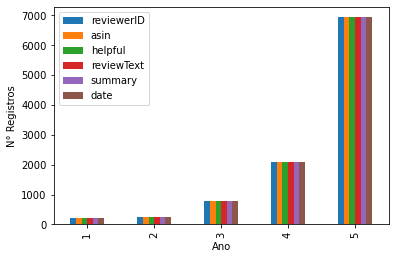

In [17]:
# Visualizando a distribuição das notas atribuídas:
df.groupby(df["overall"]).count().plot(kind="bar",xlabel='Ano',ylabel="N° Registros")

In [18]:
# Combinando as colunas 'reviewText' e 'summary':
df['reviews'] = df['reviewText'] + df['summary']
df = df.drop(['reviewText', 'summary'], axis=1)
df.head()

,reviewerID,asin,helpful,overall,date,reviews
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5,2014-02-28,"Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5,2013-03-16,The product does exactly as it should and is q...
2,A195EZSQDW3E21,1384719342,"[1, 1]",5,2013-08-28,The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5,2014-02-14,Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,1384719342,"[0, 0]",5,2014-02-21,This pop filter is great. It looks and perform...


In [19]:
# Classificando as notas por sentimento:

# Se a pontuação for maior que 3, o sentimento é Positivo
# Se o valor for menor do que 3, o sentimento é Negativo
# Se for igual a 3, o sentimento é Neutro.

def sent(rating):
    if rating['overall'] == 3:
        value = 'Neutral'
    elif rating['overall'] > 3:
        value = 'Positive'
    else:
        value = 'Negative'
    return value

#Applying the function in our new column
df['sentiment'] = df.apply(sent, axis=1)
df.head()

,reviewerID,asin,helpful,overall,date,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5,2014-02-28,"Not much to write about here, but it does exac...",Positive
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5,2013-03-16,The product does exactly as it should and is q...,Positive
2,A195EZSQDW3E21,1384719342,"[1, 1]",5,2013-08-28,The primary job of this device is to block the...,Positive
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5,2014-02-14,Nice windscreen protects my MXL mic and preven...,Positive
4,A94QU4C90B1AX,1384719342,"[0, 0]",5,2014-02-21,This pop filter is great. It looks and perform...,Positive


In [20]:
print('The count of sentiments:')
df['sentiment'].value_counts()

The count of sentiments:


Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

In [21]:
df.groupby([df["date"].dt.year,df["sentiment"]]).size()

date  sentiment
2004  Positive        7
2005  Positive        4
2006  Negative        1
      Neutral         1
      Positive        8
2007  Negative        1
      Positive       21
2008  Negative        2
      Neutral         7
      Positive       54
2009  Negative        5
      Neutral         8
      Positive      115
2010  Negative       16
      Neutral        20
      Positive      314
2011  Negative       46
      Neutral        84
      Positive      877
2012  Negative       85
      Neutral       130
      Positive     1721
2013  Negative      170
      Neutral       319
      Positive     3566
2014  Negative      141
      Neutral       203
      Positive     2335
dtype: int64

In [22]:
# Tornando a coluna 'helpful' mais informativa:

df["helpful"] = df["helpful"].astype(str)

newreview = df["helpful"].str.split(",", n = 1, expand = True)

newreview1 = newreview[0].str.split("[", n = 1, expand = True)
newreview2 = newreview[1].str.split("]", n = 1, expand = True)

#Resetting the index
newreview1.reset_index(drop=True, inplace=True)
newreview2.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
newreview1 = newreview1.drop([0], axis=1)
newreview2 = newreview2.drop([1], axis=1)

#Concatenating the splitted columns
helpfulreview = pd.concat([newreview1, newreview2], axis=1)
helpfulreview
# df.head()

#Converting into integer types
helpfulreview[0] = helpfulreview[0].astype(str).astype(int)
helpfulreview[1] = helpfulreview[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpfulreview['result'] = helpfulreview[1]/helpfulreview[0]
except ZeroDivisionError:
  helpfulreview['result']=0

#Filling the NaN values(created due to dividing) with 0
helpfulreview['result'] = helpfulreview['result'].fillna(0)

#Rounding of the results to two decimal places
helpfulreview['result'] = helpfulreview['result'].round(2) 

#Attaching the results to a new column of the main dataframe
df['helpful_review'] = helpfulreview['result']

df.head()

,reviewerID,asin,helpful,overall,date,reviews,sentiment,helpful_review
0,A2IBPI20UZIR0U,1384719342,"[0, 0]",5,2014-02-28,"Not much to write about here, but it does exac...",Positive,0.00
1,A14VAT5EAX3D9S,1384719342,"[13, 14]",5,2013-03-16,The product does exactly as it should and is q...,Positive,0.93
2,A195EZSQDW3E21,1384719342,"[1, 1]",5,2013-08-28,The primary job of this device is to block the...,Positive,1.00
3,A2C00NNG1ZQQG2,1384719342,"[0, 0]",5,2014-02-14,Nice windscreen protects my MXL mic and preven...,Positive,0.00
4,A94QU4C90B1AX,1384719342,"[0, 0]",5,2014-02-21,This pop filter is great. It looks and perform...,Positive,0.00


In [158]:
# Exportando...
df.to_json('data/dataset.json', orient='records', lines=True)

# [Análise de Texto com Elasticsearch](#analyzer)

In [181]:
# Pipeline de pré-processamento: analyzer

# !pip install elasticsearch 

ES_URL = 'https://localhost:9200'
ES_USER = 'elastic'
ES_PASS = 'elastic123'

client = Elasticsearch(
    ES_URL,
    basic_auth=(ES_USER, ES_PASS),
    verify_certs=False
)

client

C:\Users\winicius.faquieri\Anaconda3\lib\site-packages\elasticsearch\_sync\client\__init__.py:395: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


<Elasticsearch(['https://localhost:9200'])>

In [182]:
# Desligando warning para facilitar nossa vida
urllib3.disable_warnings()

dict(client.info())

{'name': 'E012366',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'Sy1H2ZYYQla4vTUqp3-s6A',
 'version': {'number': '8.2.2',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '9876968ef3c745186b94fdabd4483e01499224ef',
  'build_date': '2022-05-25T15:47:06.259735307Z',
  'build_snapshot': False,
  'lucene_version': '9.1.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

#### Customizando uma lista de stopwords para adicionar ao analyzer 

Optamos por não utilizar a biblioteca NLTK, pois algumas palavras consideradas stopwords (ex: no) poderiam ser importantes na análise

In [183]:


en_stops = ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

[Mapping e Configurações de Índice](#mapping)

Para armazenar dados (ou documentos) no Elasticsearch, é necessário fazer isso através de um index. Um index no Elasticsearch é um local para armazenar e organizar documentos relacionados. É comparável a um banco de dados contendo várias tabelas.

In [223]:
# Criando um analyzer customizado (rm caracteres especiais, transforma o token para minusculo e elimina "'" de expresões como "d'agua"):
# Pré-processamento de textos com index mapping:

INDEX_NAME = 'index_reviews_amazon'

INDEX_MAPPING = {
    "settings": {
        "number_of_shards": 3,
        "analysis": {
            "analyzer": {
                "meu_analisador": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": ["asciifolding","lowercase","elision","stopsss","stop_custom"]
                }
            },
            "filter": {
                "stopsss": {
                    "type": "stop",
                    "stopwords": "_english_",
                },
                "stop_custom": {
                    "type": "stop",
                    "stopwords": en_stops,
                },
            }
        }
    },
"mappings": {
        "properties": {
            "sentiment": {
                "type": "text",
                "fields": {
                    "raw": {
                        "type": "keyword"
                    }
                }
            },
            "reviews": {
                "type": "text",
                "analyzer": "meu_analisador",
                "fielddata": True,
                "fielddata_frequency_filter": {
                    # Deve aparecer em pelo menos em 1% dos documentos
                    "min": 0.01,
                    # Definindo um limite inferior para o nº ocorrencias
                    "min_segment_size": 10,
                 }
            }
        }
    }
}

In [224]:
# Bulk insert
def gen_documents(filename):
    with open('data/dataset.json','r') as fin:
        for line in fin:
            yield json.loads(line)

Definindo uma função geradora para transformar um iterável de documentos em um iterável de ações bulk:

In [225]:
def gen_index_actions(documents):
    for doc in documents:
        yield {
            '_op_type': 'index',
            '_index': INDEX_NAME,
            '_source': doc
        }

In [226]:
# Apagar caso o indice exista
if client.indices.exists(index=INDEX_NAME):
    client.indices.delete(index=INDEX_NAME)
client.indices.create(index=INDEX_NAME, **INDEX_MAPPING)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'index_reviews_amazon'})

In [227]:
# Testando o analyzer:
analyzed = client.indices.analyze(
    index= INDEX_NAME,
    analyzer="meu_analisador",
    text= "I got it to have it if I needed it. I have found that i don't really need it that often and rarely use it. If I was really good I can see the need. But this is a keyboard not an organ.It works great but I hardly use it.",
)

print([x["token"] for x in analyzed['tokens']])

['got', 'needed', 'found', 'really', 'need', 'often', 'rarely', 'use', 'really', 'good', 'see', 'need', 'keyboard', 'organ.it', 'works', 'great', 'hardly', 'use']


In [228]:
%%time
documents = gen_documents('data/dataset.json')
actions = gen_index_actions(documents)

success, errors = bulk(client, actions)

client.indices.refresh(index=INDEX_NAME)
client.indices.flush(index=INDEX_NAME)

Wall time: 14.1 s


ObjectApiResponse({'_shards': {'total': 6, 'successful': 3, 'failed': 0}})

Query com Agregação - Realiza operações sobre um conjunto de documentos. Comparável ao GROUP BY do SQL.

In [194]:

QUERY = {
    'match_all': {}
}

AGG = {
    'grupos': {
        'terms': {
            'field': 'sentiment.raw',
            'size': 3,
        }
    }
}

In [147]:
# Realizando uma busca:
resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=0)
resp

ObjectApiResponse({'took': 3, 'timed_out': False, '_shards': {'total': 3, 'successful': 3, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}, 'aggregations': {'grupos': {'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0, 'buckets': [{'key': 'Positive', 'doc_count': 9022}, {'key': 'Neutral', 'doc_count': 772}, {'key': 'Negative', 'doc_count': 467}]}}})

In [148]:
resp['hits']

{'total': {'value': 10000, 'relation': 'gte'}, 'max_score': None, 'hits': []}

In [151]:
resp['aggregations']

{'grupos': {'doc_count_error_upper_bound': 0,
  'sum_other_doc_count': 0,
  'buckets': [{'key': 'Positive', 'doc_count': 9022},
   {'key': 'Neutral', 'doc_count': 772},
   {'key': 'Negative', 'doc_count': 467}]}}

In [150]:
df_sentiment_agg = pd.DataFrame(resp['aggregations']['grupos']['buckets'])
df_sentiment_agg

,key,doc_count
0,Positive,9022
1,Neutral,772
2,Negative,467


<AxesSubplot:title={'center':'Distribuição de freqüência: Sentimentos'}, xlabel='key'>

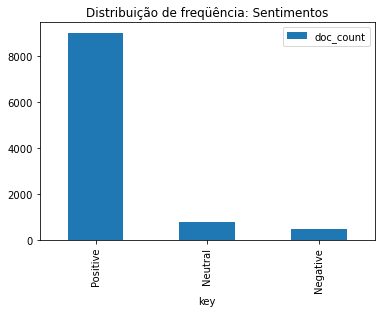

In [154]:
df_sentiment_agg.plot(title = 'Distribuição de freqüência: Sentimentos', x='key', kind='bar')

#### Wordcloud para o sentimento 'Positive'. 
Palavras como great, good, like, nice, well, quality, best, etc parece definir bem o sentimento positivo dos clientes:

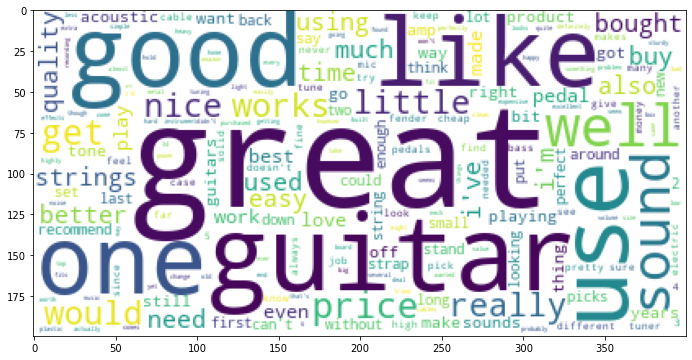

In [201]:
QUERY = {
    'term': {
        'sentiment.raw': 'Positive'
    }
}

AGG = {
    'corpo_textual': {
        'terms': {
            'field': 'reviews',
            'size': 2000,
        }
    }
}


resp = client.search(index=INDEX_NAME, query=QUERY, aggregations=AGG, size=2)


# Frequência dos tokens mais relevantes para o sentimento positivo:
frequencies = {}

buckets = resp['aggregations']['corpo_textual']['buckets']

for bucket in buckets:
    frequencies[bucket['key']] = bucket['doc_count']

frequencies

cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(frequencies)

fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(cloud)

# [Imitando k-NN com a query More Like This](#MLT)

In [ ]:
# document
doc = client.search(index=INDEX_NAME, q='great', size=150)

doc = doc['hits']['hits'][-1]

In [234]:
print(doc['_source']['sentiment'])


Positive


In [238]:
QUERY = {
    'more_like_this': {
        'fields': ['reviews'],
        'like': [
            {
                '_index': INDEX_NAME,
                '_id': 'xQ-SrIEB5LSonSuUrPch',
            }
        ],
        'min_term_freq': 1,
        'max_query_terms': 12,
    }
}
resp = client.search(index=INDEX_NAME, query=QUERY, size=10)

resp_df = pd.DataFrame({'_id': x['_id'], '_score': x['_score'], **x['_source']} for x in resp['hits']['hits'])
resp_df

,_id,_score,reviewerID,asin,helpful,overall,date,reviews,sentiment,helpful_review
0,9BCSrIEB5LSonSuU1xl6,14.878317,A3KZEGBTPH6MMF,B00IZCSW3M,"[0, 0]",5,1402704000000,My father is a full-time gigging musician prim...,Positive,0.00
1,BA-SrIEB5LSonSuUrvkU,13.420241,ABC68JUCPTVOE,B0002E3CHC,"[0, 0]",5,1365033600000,I'm impressed with these EXP16 guitar strings....,Positive,0.00
2,4hCSrIEB5LSonSuU1xl6,12.940178,A29B4PAIOL7HYG,B00HFRXACG,"[1, 1]",5,1402444800000,I have to admit this up front - I'm a terrible...,Positive,1.00
3,BQ-SrIEB5LSonSuUrvkU,12.078281,A22Z554ZQ8NFPC,B0002E3CHC,"[2, 2]",5,1299024000000,"I've used D'Addario strings for many, many yea...",Positive,1.00
4,TBCSrIEB5LSonSuUxQVC,11.745450,A24Z0TLWP8FXGV,B000KIRT74,"[0, 0]",5,1395619200000,I love this pedal. It gives just the right amo...,Positive,0.00
5,CBCSrIEB5LSonSuU1xp6,11.617835,A1SD1C8XK3Z3V1,B00JBIVXGC,"[0, 0]",5,1404086400000,I've used Elixirs for about five years now. Th...,Positive,0.00
6,8Q-SrIEB5LSonSuUsfz_,11.429770,A9P4Q7KX35RS2,B0002H04NE,"[0, 0]",5,1390694400000,I usually use the Pro Steels (by D'Addario) b...,Positive,0.00
7,AQ-SrIEB5LSonSuUsf3_,11.403111,A398X9POBHK69N,B0002H0A3S,"[0, 0]",5,1383177600000,These were the same strings originally strung ...,Positive,0.00
8,Cw-SrIEB5LSonSuUrvkU,11.313062,A1LHMSY3Q46PJS,B0002E3CHC,"[5, 6]",5,1197158400000,I've been using these strings for about eight ...,Positive,0.83
9,TQ-SrIEB5LSonSuUsf3_,11.042872,A2SKZZZBV1XYWP,B0002H0A3S,"[8, 10]",5,1268524800000,Not much to say here. Strings are a very perso...,Positive,0.80


In [239]:
# Classificação baseado somente nos 10 mais próximos
resp_df['sentiment'].value_counts()

Positive    10
Name: sentiment, dtype: int64

In [241]:
# Definindo um classificador:
def classify_with_score(like, size=10):
    
    query = {
        'more_like_this': {
            'fields': ['reviews'],
            'like': like,
            'min_term_freq': 1,
            'max_query_terms': 12,
        }
    }
    
    resp = client.search(index=INDEX_NAME, query=query, size=size)
    
    resp_df = pd.DataFrame(
        {
            '_id': x['_id'],
            '_score': x['_score'],
            **x['_source']
        } for x in resp['hits']['hits']
    )
    return resp_df.groupby('sentiment').sum().index[0]

In [246]:
like = [
    {
        '_index': INDEX_NAME,
        '_id': 'Cw-SrIEB5LSonSuUrvkU',
    }
]
classify_with_score(like)

'Positive'

In [247]:
def classify_document(doc_id, size=10):
    
    return classify_with_score(
        [
            {
                '_index': INDEX_NAME,
                '_id': doc_id
            }
        ]
    )

In [248]:
classify_document('Cw-SrIEB5LSonSuUrvkU')

'Positive'

#### [Avaliando o "classificador"](#avaliar)

In [251]:
test_docs_resp = client.search(index=INDEX_NAME, size=100, _source=['sentiment'])

test_docs = pd.DataFrame(
        {
            '_id': x['_id'],
            **x['_source']
        } for x in test_docs_resp['hits']['hits']
    )
test_docs

,_id,sentiment
0,_g-SrIEB5LSonSuUp_Gk,Positive
1,_w-SrIEB5LSonSuUp_Gk,Positive
2,AA-SrIEB5LSonSuUp_Kk,Positive
3,Ag-SrIEB5LSonSuUp_Kk,Positive
4,BA-SrIEB5LSonSuUp_Kk,Positive
...,...,...
95,KQ-SrIEB5LSonSuUp_Ok,Positive
96,Lg-SrIEB5LSonSuUp_Ok,Neutral
97,Mg-SrIEB5LSonSuUp_Ok,Positive
98,Ng-SrIEB5LSonSuUp_Ok,Positive


In [253]:
test_docs['predicted'] = test_docs['_id'].apply(classify_document)

test_docs

,_id,sentiment,predicted
0,_g-SrIEB5LSonSuUp_Gk,Positive,Negative
1,_w-SrIEB5LSonSuUp_Gk,Positive,Negative
2,AA-SrIEB5LSonSuUp_Kk,Positive,Positive
3,Ag-SrIEB5LSonSuUp_Kk,Positive,Positive
4,BA-SrIEB5LSonSuUp_Kk,Positive,Positive
...,...,...,...
95,KQ-SrIEB5LSonSuUp_Ok,Positive,Neutral
96,Lg-SrIEB5LSonSuUp_Ok,Neutral,Negative
97,Mg-SrIEB5LSonSuUp_Ok,Positive,Positive
98,Ng-SrIEB5LSonSuUp_Ok,Positive,Negative


In [256]:
print(
    classification_report(
        test_docs['sentiment'],
        test_docs['predicted']
    )
)

              precision    recall  f1-score   support

    Negative       0.03      0.50      0.05         2
     Neutral       0.00      0.00      0.00         8
    Positive       0.89      0.38      0.53        90

    accuracy                           0.35       100
   macro avg       0.31      0.29      0.19       100
weighted avg       0.81      0.35      0.48       100

